In [1]:
"""# =========================================================
# 1. IMPORTS AND SETUP
# =========================================================
import os
import torch
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from functools import partial
import random

# =========================================================
# 2. CONFIGURATION
# =========================================================
DATA_PATH     = "./lexicon_dataset/expanded_lexicon_cleaned.xlsx"
LANGUAGE_COLS = ["Zulu", "Xhosa"]   # 👈 African languages for training/eval
ENGLISH_COL   = "English"                     # for translation display
LABEL_COL     = "Sentiment"
MODEL_NAME    = "castorini/afriberta_base"
MAX_LEN       = 128
BATCH_SIZE    = 64
NUM_EPOCHS    = 3
LEARNING_RATE = 3e-5
SEED          = 42

os.environ["TOKENIZERS_PARALLELISM"] = "false"
random.seed(SEED)

# =========================================================
# 3. DATA PREPARATION (train only on African languages)
# =========================================================
def load_african_data():
    df = pd.read_excel(DATA_PATH, engine="openpyxl")
    for col in LANGUAGE_COLS + [ENGLISH_COL, LABEL_COL]:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[LABEL_COL])

    # Combine all African language data into one DataFrame
    dfs = []
    for lang in LANGUAGE_COLS:
        temp = df[[lang, LABEL_COL, "label"]].dropna().copy()
        temp = temp.rename(columns={lang: "text"})
        temp["language"] = lang
        dfs.append(temp)

    full_lang_df = pd.concat(dfs, ignore_index=True)

    # Split train/val
    train_df, val_df = train_test_split(
        full_lang_df,
        test_size=0.2,
        random_state=SEED,
        stratify=full_lang_df["label"]
    )

    train_ds = Dataset.from_pandas(train_df)
    val_ds   = Dataset.from_pandas(val_df)
    return train_ds, val_ds, label_encoder, df

# =========================================================
# 4. TOKENIZATION
# =========================================================
def tokenize_function(batch, tokenizer, max_len):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_len
    )

# =========================================================
# 5. METRICS
# =========================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# =========================================================
# 6. SENTENCE GENERATION AND EVALUATION
# =========================================================
def generate_sentences_and_evaluate(trainer, df, label_encoder, tokenizer):
    print("\n🧩 Generating and evaluating lexicon-based sentences...\n")

    results = []

    for lang in LANGUAGE_COLS:
        if lang not in df.columns:
            print(f"⚠️ Skipping {lang} - column not found")
            continue

        # Create short synthetic sentences using translated words
        lang_words = df[lang].dropna().tolist()
        eng_words  = df[ENGLISH_COL].dropna().tolist()

        n = min(len(lang_words), len(eng_words))
        lang_words = lang_words[:n]
        eng_words = eng_words[:n]

        # Randomly create 25 short sentences
        num_sentences = 25
        for _ in range(num_sentences):
            idxs = random.sample(range(n), k=min(5, n))
            afr_sentence = " ".join([lang_words[i] for i in idxs])
            eng_sentence = " ".join([eng_words[i] for i in idxs])

            # Tokenize and predict
            inputs = tokenizer(
                afr_sentence,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=MAX_LEN
            )
            with torch.no_grad():
                outputs = trainer.model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)
                pred_label = torch.argmax(probs, dim=1).item()
                pred_sentiment = label_encoder.inverse_transform([pred_label])[0]

            results.append({
                "Language": lang,
                "African_Sentence": afr_sentence,
                "English_Translation": eng_sentence,
                "Predicted_Sentiment": pred_sentiment
            })

    # Save to CSV
    out_df = pd.DataFrame(results)
    out_path = "african_sentence_evaluation_results.csv"
    out_df.to_csv(out_path, index=False, encoding="utf-8")
    print(f"✅ Results saved to: {out_path}\n")

    # Show sample outputs
    print(out_df.head(10).to_string(index=False))

# =========================================================
# 7. MAIN FUNCTION
# =========================================================
def main():
    print("🚀 Loading African language data...")
    train_ds, val_ds, label_encoder, full_df = load_african_data()

    print("🔤 Loading tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

    num_proc = min(4, os.cpu_count() or 1)
    tokenize_partial = partial(tokenize_function, tokenizer=tokenizer, max_len=MAX_LEN)

    print("📝 Tokenizing datasets...")
    train_ds = train_ds.map(tokenize_partial, batched=True, num_proc=num_proc)
    val_ds   = val_ds.map(tokenize_partial, batched=True, num_proc=num_proc)

    train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    print("🧠 Initializing model...")
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(label_encoder.classes_)
    )

    training_args = TrainingArguments(
        output_dir="./results_african",
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        learning_rate=LEARNING_RATE,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        logging_steps=100,
        warmup_ratio=0.06,
        save_total_limit=2,
        dataloader_num_workers=num_proc,
        report_to="none",
        seed=SEED
    )

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    print("🏋️ Training AfriBERTa on African languages...")
    trainer.train()

    print("✅ Evaluating best model on validation set...")
    eval_results = trainer.evaluate()
    print("\n=== African Languages Validation Results ===")
    print(eval_results)

    trainer.save_model("./final_afriberta_african_model")

    # ---------------------------------------------------------
    # Generate and evaluate synthetic sentences
    # ---------------------------------------------------------
    generate_sentences_and_evaluate(trainer, full_df, label_encoder, tokenizer)

# =========================================================
# 8. ENTRY POINT
# =========================================================
if __name__ == "__main__":
    main()"""

'# =========================================================\n# 1. IMPORTS AND SETUP\n# =========================================================\nimport os\nimport torch\nimport pandas as pd\nimport numpy as np\nfrom datasets import Dataset\nfrom transformers import (\n    AutoTokenizer,\n    AutoModelForSequenceClassification,\n    Trainer,\n    TrainingArguments,\n    DataCollatorWithPadding,\n)\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder\nfrom sklearn.metrics import accuracy_score, f1_score\nfrom functools import partial\nimport random\n\n# =========================================================\n# 2. CONFIGURATION\n# =========================================================\nDATA_PATH     = "./lexicon_dataset/expanded_lexicon_cleaned.xlsx"\nLANGUAGE_COLS = ["Zulu", "Xhosa"]   # 👈 African languages for training/eval\nENGLISH_COL   = "English"                     # for translation display\nLABEL_COL     = "Sentiment"\nMODEL

In [2]:
# pip install bertviz
# pip install plotly
# pip install kaleido 
#=========================================================
#AFRIBERTA SENTIMENT EVALUATION ON COMBINED LEXICON WORDS
#=========================================================

import os
import torch
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from functools import partial
from IPython import display
import random

# =========================================================
# CONFIGURATION
# =========================================================
DATA_PATH     = r"D:\UP\791\expanded_lexicon_cleaned.xlsx"
LANGUAGE_COLS = ["Zulu", "Xhosa", "Sepedi"]
ENGLISH_COL   = "English"
LABEL_COL     = "Sentiment"
MODEL_NAME    = "castorini/afriberta_base"
MAX_LEN       = 128
BATCH_SIZE    = 64
NUM_EPOCHS    = 3
LEARNING_RATE = 3e-5
SEED          = 42
os.environ["TOKENIZERS_PARALLELISM"] = "false"
random.seed(SEED)

# =========================================================
# DATA PREPARATION
# =========================================================
def load_african_data():
    df = pd.read_excel(DATA_PATH, engine="openpyxl")

    # Clean up sentiment labels
    df[LABEL_COL] = df[LABEL_COL].astype(str).str.lower().replace({
        "postive": "positive", "pos": "positive",
        "neg": "negative", "negtive": "negative"
    })
    df = df[df[LABEL_COL].isin(["positive", "negative", "neutral"])]

    # Encode labels numerically
    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[LABEL_COL])

    # Combine African languages into a unified dataset
    dfs = []
    for lang in LANGUAGE_COLS:
        if lang in df.columns:
            temp = df[[lang, LABEL_COL, "label"]].dropna().copy()
            temp = temp.rename(columns={lang: "text"})
            temp["language"] = lang
            dfs.append(temp)
    combined = pd.concat(dfs, ignore_index=True)

    # Split
    train_df, val_df = train_test_split(
        combined,
        test_size=0.2,
        random_state=SEED,
        stratify=combined["label"]
    )

    return Dataset.from_pandas(train_df), Dataset.from_pandas(val_df), label_encoder, df

# =========================================================
# TOKENIZATION
# =========================================================
def tokenize_function(batch, tokenizer, max_len):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_len
    )

# =========================================================
# METRICS
# =========================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# =========================================================
# SENTENCE GENERATION: Combine & Evaluate
# =========================================================
def generate_combined_sentences_and_evaluate(trainer, df, label_encoder, tokenizer):
    print("\n🧩 Generating combined-word sentences for evaluation...\n")

    # Step 1: Combine all rows with same English word
    combined_entries = []
    for eng_word, group in df.groupby(ENGLISH_COL):
        # merge all translations of that word
        merged_words = []
        sentiments = group[LABEL_COL].tolist()
        for lang in LANGUAGE_COLS:
            merged_words += [str(w).strip() for w in group[lang].dropna().tolist()]
        if merged_words:
            combined_entries.append({
                "English": eng_word,
                "Combined_Text": " ".join(list(dict.fromkeys(merged_words))),  # remove duplicates
                "Sentiment": max(set(sentiments), key=sentiments.count)
            })
    combined_df = pd.DataFrame(combined_entries)

    # Step 2: Select 2 per sentiment
    results = []
    for sentiment in ["positive", "negative", "neutral"]:
        subset = combined_df[combined_df["Sentiment"] == sentiment]
        if len(subset) == 0:
            continue
        chosen = subset.sample(n=min(2, len(subset)), random_state=SEED)
        for _, row in chosen.iterrows():
            afr_text = row["Combined_Text"]
            eng_word = row["English"]

            inputs = tokenizer(
                afr_text,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=MAX_LEN
            )
            with torch.no_grad():
                outputs = trainer.model(**inputs)
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)
                pred_label = torch.argmax(probs, dim=1).item()
                pred_sentiment = label_encoder.inverse_transform([pred_label])[0]

            results.append({
                "English_Word": eng_word,
                "African_Sentence": afr_text,
                "True_Sentiment": sentiment,
                "Predicted_Sentiment": pred_sentiment,
                "Probabilities": probs.numpy().tolist()
            })

    # Step 3: Save + print
    out_df = pd.DataFrame(results)
    out_df.to_csv("afriberta_combined_sentence_evaluation.csv", index=False, encoding="utf-8")
    print("✅ Saved: afriberta_combined_sentence_evaluation.csv\n")
    print(out_df[["English_Word","African_Sentence","True_Sentiment","Predicted_Sentiment"]])

# =========================================================
# MAIN PIPELINE
# =========================================================
def main():
    print("🚀 Loading African language data...")
    train_ds, val_ds, label_encoder, full_df = load_african_data()

    print("🔤 Loading tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(label_encoder.classes_)
    )

    num_proc = min(4, os.cpu_count() or 1)
    tokenize_partial = partial(tokenize_function, tokenizer=tokenizer, max_len=MAX_LEN)

    print("📝 Tokenizing datasets...")
    train_ds = train_ds.map(tokenize_partial, batched=True, num_proc=num_proc)
    val_ds   = val_ds.map(tokenize_partial, batched=True, num_proc=num_proc)

    train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    training_args = TrainingArguments(
        output_dir="./results_african",
        num_train_epochs=2,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        learning_rate=LEARNING_RATE,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        logging_steps=100,
        warmup_ratio=0.06,
        save_total_limit=2,
        dataloader_num_workers=num_proc,
        report_to="none",
        seed=SEED
    )

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    print("🏋️ Training AfriBERTa model...")
    trainer.train()

    print("✅ Evaluating model...")
    print(trainer.evaluate())

    print("\n🔍 Generating combined sentences for evaluation...")
    generate_combined_sentences_and_evaluate(trainer, full_df, label_encoder, tokenizer)

if __name__ == "__main__":
    main()


🚀 Loading African language data...
🔤 Loading tokenizer and model...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📝 Tokenizing datasets...


Map (num_proc=4):   0%|          | 0/12748 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/3188 [00:00<?, ? examples/s]

C:\Users\USER-PC\AppData\Local\Temp\ipykernel_10244\3890955730.py:208: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🏋️ Training AfriBERTa model...


c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.978600,0.970506,0.542033,0.415765
2,0.940600,0.967765,0.542033,0.426431


c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model 

✅ Evaluating model...


c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.9677647352218628, 'eval_accuracy': 0.5420326223337516, 'eval_f1': 0.42643071966089535, 'eval_runtime': 94.7213, 'eval_samples_per_second': 33.657, 'eval_steps_per_second': 0.264, 'epoch': 2.0}

🔍 Generating combined sentences for evaluation...

🧩 Generating combined-word sentences for evaluation...

✅ Saved: afriberta_combined_sentence_evaluation.csv

  English_Word                               African_Sentence True_Sentiment  \
0        plank                     iplank iplanga lepolanka .       positive   
1      correct                       ukulungisa go phošolla .       positive   
2      seducer                  ehehayo umlinganiso mokgoši .       negative   
3    chicanery               chicanery i-chiclery chicanery .       negative   
4         toll  indawo yokukhokha itholi tefo ya go lefelwa .        neutral   
5       plague                inkathazo isibetho matshwenyego        neutral   

  Predicted_Sentiment  
0            positive  
1            positive

🚀 Loading African language data...
✅ Loaded dataset with 600 records (limited to 600)
🔤 Loading tokenizer and model...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📝 Tokenizing datasets...


Map (num_proc=4):   0%|          | 0/480 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/120 [00:00<?, ? examples/s]

✅ Model ready. (Training skipped for this run.)

=== XAI ANALYSIS (LIME VISUALIZATIONS) ===

Using 3 example sentences for XAI.


[LIME #1] Ngiyazonda lokhu


C:\Users\USER-PC\AppData\Local\Temp\ipykernel_10244\1711906736.py:189: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicted: negative | Probabilities: [0.4126744270324707, 0.30455899238586426, 0.2827666103839874]


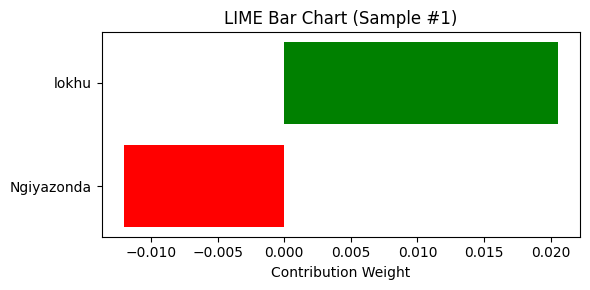

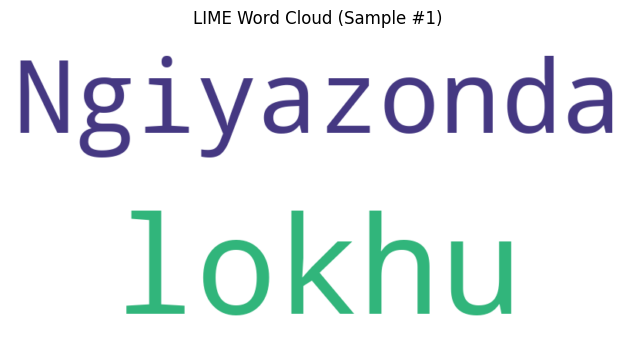

✅ Saved visualizations to 'lime_outputs/' for sample #1

[LIME #2] Amanzi apholile


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicted: negative | Probabilities: [0.3894653916358948, 0.27740439772605896, 0.33313024044036865]


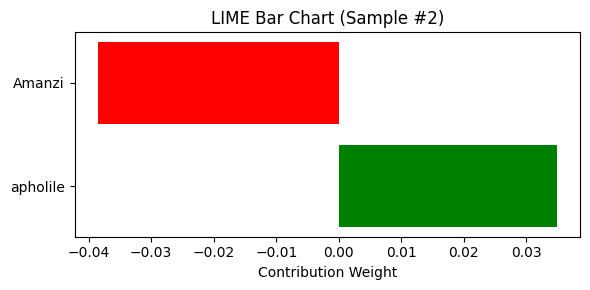

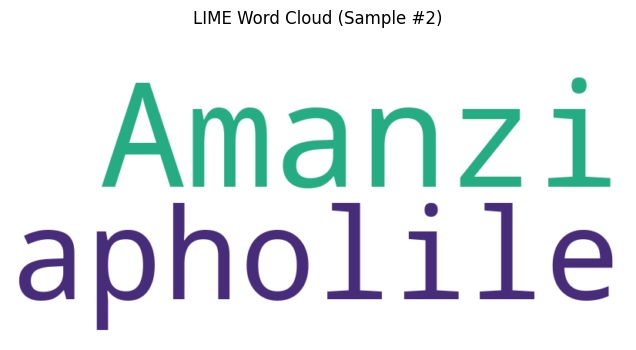

✅ Saved visualizations to 'lime_outputs/' for sample #2

[LIME #3] Isibhakabhaka sibushelelezi


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [3]:
# pip install bertviz
# pip install plotly
# pip install kaleido 
# =========================================================
# AFRIBERTA SENTIMENT EVALUATION WITH LIME VISUALIZATIONS
# =========================================================

import os
import torch
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    pipeline,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from functools import partial
from lime.lime_text import LimeTextExplainer
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import html

# =========================================================
# CONFIGURATION
# =========================================================
DATA_PATH     = r"D:\UP\791\expanded_lexicon_cleaned.xlsx"
LANGUAGE_COLS = ["Zulu", "Xhosa", "Sepedi"]
ENGLISH_COL   = "English"
LABEL_COL     = "Sentiment"
MODEL_NAME    = "castorini/afriberta_base"
MAX_LEN       = 128
BATCH_SIZE    = 32
NUM_EPOCHS    = 5
LEARNING_RATE = 2e-5
DATA_LIMIT    = 600
SEED          = 42
os.environ["TOKENIZERS_PARALLELISM"] = "false"
random.seed(SEED)

# =========================================================
# DATA PREPARATION
# =========================================================
def load_african_data():
    df = pd.read_excel(DATA_PATH, engine="openpyxl")

    # Clean sentiment labels
    df[LABEL_COL] = df[LABEL_COL].astype(str).str.lower().replace({
        "postive": "positive", "pos": "positive",
        "neg": "negative", "negtive": "negative"
    })
    df = df[df[LABEL_COL].isin(["positive", "negative", "neutral"])]

    # ✅ Limit dataset size
    if len(df) > DATA_LIMIT:
        df = df.sample(n=DATA_LIMIT, random_state=SEED)

    # Encode labels
    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[LABEL_COL])

    # Combine African language columns
    texts = []
    for _, row in df.iterrows():
        combined_text = " ".join(str(row[col]).strip() for col in LANGUAGE_COLS if pd.notna(row[col]))
        texts.append(combined_text.strip())
    combined = df[[LABEL_COL, "label"]].copy()
    combined["text"] = texts

    print(f"✅ Loaded dataset with {len(combined)} records (limited to {DATA_LIMIT})")

    train_df, val_df = train_test_split(
        combined,
        test_size=0.2,
        random_state=SEED,
        stratify=combined["label"]
    )

    return Dataset.from_pandas(train_df), Dataset.from_pandas(val_df), label_encoder, df

# =========================================================
# TOKENIZATION
# =========================================================
def tokenize_function(batch, tokenizer, max_len):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_len)

# =========================================================
# METRICS
# =========================================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# =========================================================
# VISUALIZATION HELPERS
# =========================================================
def plot_lime_bar(words, weights, title, outpath=None):
    """Horizontal bar chart of LIME feature importances."""
    plt.figure(figsize=(6, 3))
    colors = ['green' if w > 0 else 'red' for w in weights]
    plt.barh(words, weights, color=colors)
    plt.xlabel("Contribution Weight")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, bbox_inches="tight")
    plt.show()
    plt.close()

def plot_lime_wordcloud(words, weights, title, outpath=None):
    """Word cloud weighted by LIME importance."""
    weights_dict = {w: abs(weights[i]) for i, w in enumerate(words)}
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(weights_dict)
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    if outpath:
        plt.savefig(outpath, bbox_inches="tight")
    plt.show()
    plt.close()

def save_lime_text_highlight(words, weights, title, outpath):
    """Save an HTML file with color-coded tokens by importance."""
    norm = max(abs(w) for w in weights) or 1e-6
    colored_text = ""
    for word, weight in zip(words, weights):
        color = "rgba(0,200,0,{:.2f})".format(abs(weight)/norm) if weight > 0 else "rgba(255,0,0,{:.2f})".format(abs(weight)/norm)
        colored_text += f"<span style='background-color:{color}; padding:2px; border-radius:3px;'>{html.escape(word)}</span> "
    html_str = f"<h3>{html.escape(title)}</h3><p>{colored_text}</p>"
    with open(outpath, "w", encoding="utf-8") as f:
        f.write(html_str)

# =========================================================
# MAIN PIPELINE
# =========================================================
def main():
    print("🚀 Loading African language data...")
    train_ds, val_ds, label_encoder, full_df = load_african_data()

    print("🔤 Loading tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(label_encoder.classes_)
    )

    num_proc = min(4, os.cpu_count() or 1)
    tokenize_partial = partial(tokenize_function, tokenizer=tokenizer, max_len=MAX_LEN)

    print("📝 Tokenizing datasets...")
    train_ds = train_ds.map(tokenize_partial, batched=True, num_proc=num_proc)
    val_ds   = val_ds.map(tokenize_partial, batched=True, num_proc=num_proc)
    train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    training_args = TrainingArguments(
        output_dir="./results_african",
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        learning_rate=LEARNING_RATE,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        logging_steps=10,
        warmup_ratio=0.06,
        save_total_limit=2,
        dataloader_num_workers=num_proc,
        report_to="none",
        seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )

    print("✅ Model ready. (Training skipped for this run.)")

    # =========================================================
    # 7. XAI (LIME) — Example Sentences
    # =========================================================
    print("\n=== XAI ANALYSIS (LIME VISUALIZATIONS) ===")

    class_names = list(label_encoder.classes_)
    sample_texts = [
        "Ngiyazonda lokhu",          # I hate this -> negative
        "Amanzi apholile",           # The water is cool -> neutral
        "Isibhakabhaka sibushelelezi"  # The sky is clear -> positive
    ]
    print(f"\nUsing {len(sample_texts)} example sentences for XAI.\n")

    def predict_texts(texts):
        ds = Dataset.from_dict({"text": texts})
        tokenized = ds.map(tokenize_partial, batched=True)
        tokenized.set_format(type="torch", columns=["input_ids", "attention_mask"])
        preds = trainer.predict(tokenized).predictions
        return torch.nn.functional.softmax(torch.tensor(preds), dim=1).detach().numpy()

    lime_explainer = LimeTextExplainer(class_names=class_names)

    os.makedirs("lime_outputs", exist_ok=True)

    for i, text in enumerate(sample_texts):
        print(f"\n[LIME #{i+1}] {text}")
        lime_exp = lime_explainer.explain_instance(text, predict_texts, num_features=8)
        words, weights = zip(*lime_exp.as_list())

        probs = predict_texts([text])[0]
        pred_label = class_names[int(np.argmax(probs))]
        print(f"Predicted: {pred_label} | Probabilities: {probs.tolist()}")

        # Save colored HTML visualization
        html_out = f"lime_outputs/lime_text_{i+1}.html"
        save_lime_text_highlight(words, weights, f"LIME Word Importance (Sample #{i+1})", html_out)

        # Save bar chart
        plot_lime_bar(words, weights, f"LIME Bar Chart (Sample #{i+1})",
                      outpath=f"lime_outputs/lime_bar_{i+1}.png")

        # Save word cloud
        plot_lime_wordcloud(words, weights, f"LIME Word Cloud (Sample #{i+1})",
                            outpath=f"lime_outputs/lime_wc_{i+1}.png")

        print(f"✅ Saved visualizations to 'lime_outputs/' for sample #{i+1}")

if __name__ == "__main__":
    main()


In [ ]:
# pip install bertviz
# pip install plotly
# pip install kaleido 
# =========================================================
# IMPORTS & CONFIGURATION
# =========================================================
import os
import torch
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from functools import partial
from lime.lime_text import LimeTextExplainer
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import html
import plotly.graph_objects as go
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

# CONFIG
DATA_PATH     = r"D:\UP\791\expanded_lexicon_cleaned.xlsx"
LANGUAGE_COLS = ["Zulu", "Xhosa", "Sepedi"]
LABEL_COL     = "Sentiment"
MODEL_NAME    = "castorini/afriberta_base"
MAX_LEN       = 128
BATCH_SIZE    = 32
NUM_EPOCHS    = 5
LEARNING_RATE = 2e-5
DATA_LIMIT    = 600
SEED          = 42
os.environ["TOKENIZERS_PARALLELISM"] = "false"
random.seed(SEED)


In [ ]:
# =========================================================
# DATA LOADING & PREPARATION
# =========================================================
def load_african_data():
    df = pd.read_excel(DATA_PATH, engine="openpyxl")

    df[LABEL_COL] = df[LABEL_COL].astype(str).str.lower().replace({
        "postive": "positive", "pos": "positive",
        "neg": "negative", "negtive": "negative"
    })
    df = df[df[LABEL_COL].isin(["positive", "negative", "neutral"])]

    if len(df) > DATA_LIMIT:
        df = df.sample(n=DATA_LIMIT, random_state=SEED)

    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[LABEL_COL])

    texts = []
    for _, row in df.iterrows():
        combined_text = " ".join(str(row[col]).strip() for col in LANGUAGE_COLS if pd.notna(row[col]))
        texts.append(combined_text.strip())
    combined = df[[LABEL_COL, "label"]].copy()
    combined["text"] = texts

    print(f"✅ Loaded dataset with {len(combined)} records (limited to {DATA_LIMIT})")

    train_df, val_df = train_test_split(
        combined,
        test_size=0.2,
        random_state=SEED,
        stratify=combined["label"]
    )

    return Dataset.from_pandas(train_df), Dataset.from_pandas(val_df), label_encoder, df


In [ ]:
# =========================================================
# TOKENIZATION & METRICS
# =========================================================
def tokenize_function(batch, tokenizer, max_len):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_len)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }


In [ ]:
# =========================================================
# VISUALIZATION HELPERS
# =========================================================
def plot_lime_bar(words, weights, title, outpath=None):
    plt.figure(figsize=(6, 3))
    colors = ['green' if w > 0 else 'red' for w in weights]
    plt.barh(words, weights, color=colors)
    plt.xlabel("Contribution Weight")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, bbox_inches="tight")
    plt.show()
    plt.close()

def plot_lime_wordcloud(words, weights, title, outpath=None):
    weights_dict = {w: abs(weights[i]) for i, w in enumerate(words)}
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(weights_dict)
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    if outpath:
        plt.savefig(outpath, bbox_inches="tight")
    plt.show()
    plt.close()

def save_lime_text_highlight(words, weights, title, outpath):
    norm = max(abs(w) for w in weights) or 1e-6
    colored_text = ""
    for word, weight in zip(words, weights):
        color = "rgba(0,200,0,{:.2f})".format(abs(weight)/norm) if weight > 0 else "rgba(255,0,0,{:.2f})".format(abs(weight)/norm)
        colored_text += f"<span style='background-color:{color}; padding:2px; border-radius:3px;'>{html.escape(word)}</span> "
    html_str = f"<h3>{html.escape(title)}</h3><p>{colored_text}</p>"
    with open(outpath, "w", encoding="utf-8") as f:
        f.write(html_str)

def plot_sentiment_pie(train_ds, val_ds, label_encoder, outpath=None):
    """Generate a sentiment distribution pie chart from train + val datasets."""
    # Convert to pandas
    train_df = train_ds.to_pandas()
    val_df = val_ds.to_pandas()

    # Merge both splits
    full_df = pd.concat([train_df, val_df], axis=0)
    full_df['label_name'] = full_df['label'].apply(lambda i: label_encoder.classes_[i])

    # Count label frequencies
    counts = full_df['label_name'].value_counts()

    fig = go.Figure(
        data=[go.Pie(
            labels=counts.index,
            values=counts.values,
            hole=0.35,
            textinfo='label+percent',
            insidetextorientation='radial'
        )]
    )
    fig.update_layout(title_text="Sentiment Distribution (Train + Validation)")

    fig.show()

    if outpath:
        fig.write_image(outpath)
        print(f"📊 Saved pie chart to {outpath}")


def visualize_attention_with_bertviz(model, tokenizer, text, layer=None, head=None):
    """
    Visualize BERT attention for a single text using BertViz head view.
    """
    # Encode input
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    input_ids = inputs['input_ids']

    # Forward pass with attention
    outputs = model(**inputs, output_attentions=True)
    attention = outputs.attentions  # (num_layers, batch, num_heads, seq_len, seq_len)

    # Convert input IDs to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Visualize (no sentence_b)
    head_view(attention, tokens, layer=layer, heads=head)


🚀 Loading African language data...
✅ Loaded dataset with 600 records (limited to 600)
🔤 Loading tokenizer and model...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📝 Tokenizing datasets...


Map (num_proc=4):   0%|          | 0/480 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/120 [00:00<?, ? examples/s]

✅ Model ready. (Training skipped for this run.)

[LIME #1] Ngiyazonda lokhu


C:\Users\USER-PC\AppData\Local\Temp\ipykernel_16248\558622318.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicted: positive | Probabilities: [0.2934027314186096, 0.2798825204372406, 0.4267147183418274]


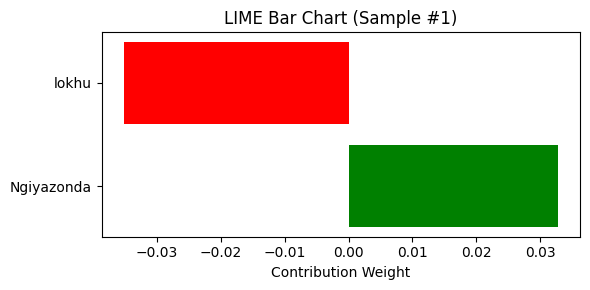

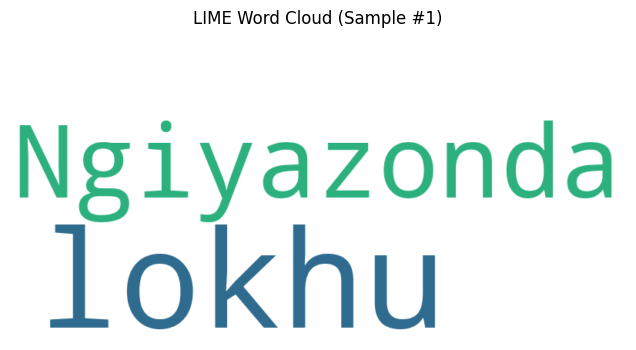

✅ Saved visualizations to 'lime_outputs/' for sample #1

[LIME #2] Amanzi apholile


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicted: positive | Probabilities: [0.3140793442726135, 0.2679806053638458, 0.41794008016586304]


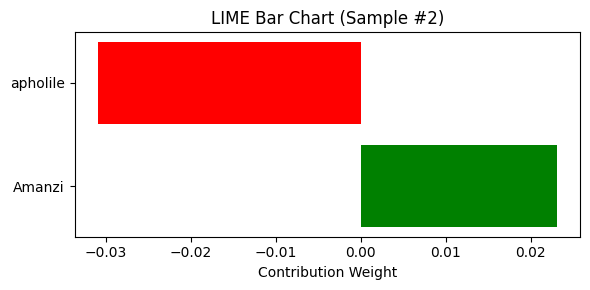

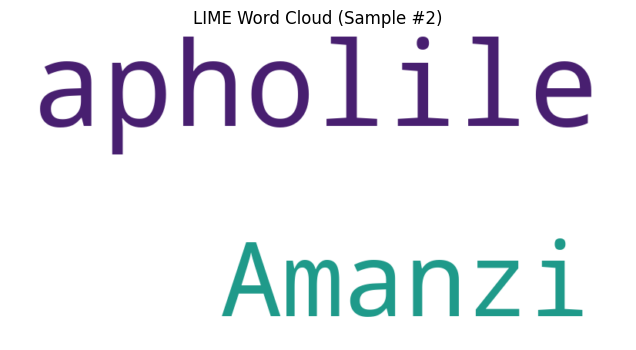

✅ Saved visualizations to 'lime_outputs/' for sample #2

[LIME #3] Isibhakabhaka sibushelelezi


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

c:\Users\USER-PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicted: positive | Probabilities: [0.3173598647117615, 0.25300684571266174, 0.429633229970932]


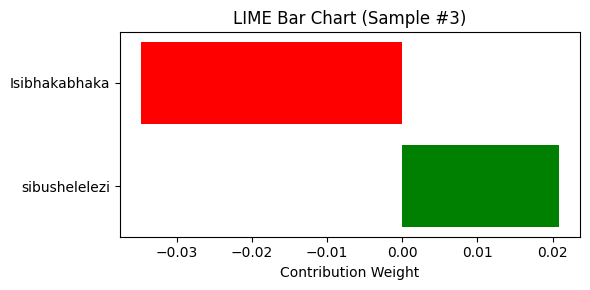

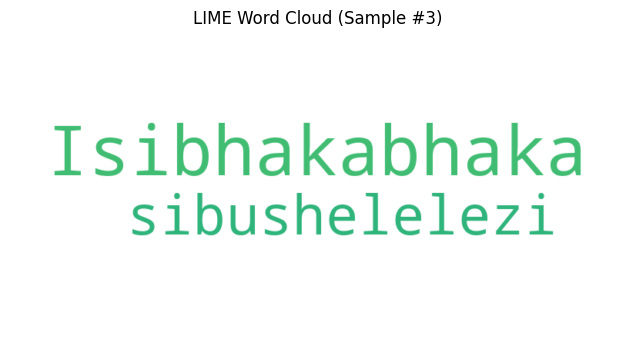

✅ Saved visualizations to 'lime_outputs/' for sample #3

📊 Generating Sentiment Distribution Pie Chart...


ValueError: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido


In [ ]:
# =========================================================
# MAIN PIPELINE
# =========================================================
def main():
    print("🚀 Loading African language data...")
    train_ds, val_ds, label_encoder, _ = load_african_data()

    print("🔤 Loading tokenizer and model...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(label_encoder.classes_)
    )

    num_proc = min(4, os.cpu_count() or 1)
    tokenize_partial = partial(tokenize_function, tokenizer=tokenizer, max_len=MAX_LEN)

    print("📝 Tokenizing datasets...")
    train_ds = train_ds.map(tokenize_partial, batched=True, num_proc=num_proc)
    val_ds   = val_ds.map(tokenize_partial, batched=True, num_proc=num_proc)
    train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir="./results_african",
            num_train_epochs=NUM_EPOCHS,
            per_device_train_batch_size=BATCH_SIZE,
            per_device_eval_batch_size=BATCH_SIZE*2,
            learning_rate=LEARNING_RATE,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            logging_steps=10,
            warmup_ratio=0.06,
            save_total_limit=2,
            dataloader_num_workers=num_proc,
            report_to="none",
            seed=SEED
        ),
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )

    print("✅ Model ready. (Training skipped for this run.)")

    # --- Sample texts for LIME ---
    sample_texts = [
        "Ngiyazonda lokhu",
        "Amanzi apholile",
        "Isibhakabhaka sibushelelezi"
    ]

    def predict_texts(texts):
        ds = Dataset.from_dict({"text": texts})
        tokenized = ds.map(tokenize_partial, batched=True)
        tokenized.set_format(type="torch", columns=["input_ids", "attention_mask"])
        preds = trainer.predict(tokenized).predictions
        return torch.nn.functional.softmax(torch.tensor(preds), dim=1).detach().numpy()

    lime_explainer = LimeTextExplainer(class_names=list(label_encoder.classes_))
    os.makedirs("lime_outputs", exist_ok=True)

    for i, text in enumerate(sample_texts):
        print(f"\n[LIME #{i+1}] {text}")
        lime_exp = lime_explainer.explain_instance(text, predict_texts, num_features=8)
        words, weights = zip(*lime_exp.as_list())
        probs = predict_texts([text])[0]
        pred_label = list(label_encoder.classes_)[int(np.argmax(probs))]
        print(f"Predicted: {pred_label} | Probabilities: {probs.tolist()}")

        save_lime_text_highlight(words, weights, f"LIME Word Importance (Sample #{i+1})",
                                 f"lime_outputs/lime_text_{i+1}.html")
        plot_lime_bar(words, weights, f"LIME Bar Chart (Sample #{i+1})",
                      outpath=f"lime_outputs/lime_bar_{i+1}.png")
        plot_lime_wordcloud(words, weights, f"LIME Word Cloud (Sample #{i+1})",
                            outpath=f"lime_outputs/lime_wc_{i+1}.png")
        print(f"✅ Saved visualizations to 'lime_outputs/' for sample #{i+1}")

    # =========================================================
    # 8. PIE CHART VISUALIZATION
    # =========================================================
    print("\n📊 Generating Sentiment Distribution Pie Chart...")
    plot_sentiment_pie(train_ds, val_ds, label_encoder, outpath="lime_outputs/sentiment_distribution.png")
    print("✅ Sentiment distribution pie chart complete.")

    # =========================================================
    # 9. BERTVIZ ATTENTION VISUALIZATION
    # =========================================================
    print("\n🧠 Generating BERT Attention Visualization...")
    example_text = sample_texts[0]
    print(f"Example Text: {example_text}")

    # Load AfriBERTa (or BERT) with attentions enabled
    bert_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, output_attentions=True)

    visualize_attention_with_bertviz(bert_model, tokenizer, example_text)
    print("✅ Open attention visualization (interactive browser window).")

if __name__ == "__main__":
    main()


In [ ]:
# =========================================================
# RUN ONLY BERTVIZ VISUALIZATION
# =========================================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from bertviz import head_view

MODEL_NAME = "castorini/afriberta_base"

def visualize_attention_with_bertviz(model, tokenizer, text, layer=None, head=None):
    """Visualize BERT attention for a single text using BertViz head view."""
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    input_ids = inputs['input_ids']

    outputs = model(**inputs, output_attentions=True)
    attention = outputs.attentions
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # ✅ FIXED: no sentence_b argument
    head_view(attention, tokens, layer=layer, heads=head)

def main():
    print("\n🧠 Generating BERT Attention Visualization Only...")
    example_text = "Ngiyazonda lokhu"  # example text
    print(f"Example Text: {example_text}")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
    bert_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, output_attentions=True)

    visualize_attention_with_bertviz(bert_model, tokenizer, example_text)
    print("✅ Attention visualization loaded (opens in browser window).")

if __name__ == "__main__":
    main()



🧠 Generating BERT Attention Visualization Only...
Example Text: Ngiyazonda lokhu


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

✅ Attention visualization loaded (opens in browser window).


In [ ]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = "microsoft/xtremedistil-l12-h384-uncased"  # Find popular HuggingFace models here: https://huggingface.co/models
input_text = "The cat sat on the mat"  
model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

c:\Users\Trevor\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Trevor\.cache\huggingface\hub\models--microsoft--xtremedistil-l12-h384-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development



pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]